In [1]:
import pandas as pd
import numpy as np

/Users/vega7unk/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import os
print(os.getcwd())

/Users/vega7unk/Documents/4th Sem DSI/ilab project/ilab-group-12-1-fall-detection/notebooks


In [3]:
pd.set_option('display.max_columns', None)

df = pd.read_pickle("../data/df_filtered_cnn.pkl")

In [4]:
df.head()

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,label
timestamp,,,,,,,
1970-01-01 00:38:38.700,0.209754,-2.331582,-0.203113,0.037081,0.031012,-0.012518,BSC
1970-01-01 00:38:38.800,0.203321,-2.349069,-0.194536,0.066225,0.079630,0.009396,BSC
1970-01-01 00:38:38.900,0.249716,-2.355785,-0.211275,0.196319,0.130287,0.033033,BSC
1970-01-01 00:38:39.000,0.276253,-2.345908,-0.201750,0.452604,0.035785,0.063763,BSC
1970-01-01 00:38:39.100,0.229522,-2.311028,-0.161954,0.682246,0.042157,0.127645,BSC


In [5]:
df_filtered = df.copy()

## Segment Data into Windows

Define a function to create windows of your desired size (e.g., 2.5-second windows):

Window size: 25 samples (2.5 sec at 10 Hz)

Overlap: 50% (step = 12 samples)


In [7]:
sensor_cols = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

def create_windows(data, window_size=25, step_size=12):
    X, y = [], []
    data_array = data[sensor_cols].values
    labels = data['label'].values

    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        window_data = data_array[start:end]
        window_labels = labels[start:end]

        # Majority voting for label assignment
        unique, counts = np.unique(window_labels, return_counts=True)
        label = unique[np.argmax(counts)]

        X.append(window_data)
        y.append(label)

    return np.array(X), np.array(y)

X, y = create_windows(df_filtered)

This generates windows of data (X) with corresponding labels (y).

In [8]:
print(X)

[[[ 2.09753762e-01 -2.33158229e+00 -2.03113398e-01  3.70812682e-02
    3.10115054e-02 -1.25182724e-02]
  [ 2.03320651e-01 -2.34906933e+00 -1.94536220e-01  6.62249324e-02
    7.96303192e-02  9.39584800e-03]
  [ 2.49716445e-01 -2.35578524e+00 -2.11275467e-01  1.96319221e-01
    1.30286749e-01  3.30328456e-02]
  ...
  [-1.46313134e+00 -2.15358967e-01  1.80649612e+00 -7.01817974e-01
    2.03801705e+00  1.05425421e+00]
  [-1.84548319e+00 -1.05669113e-01  1.41928172e+00  1.78329410e-01
    2.40513754e+00  1.55617658e+00]
  [-1.93079213e+00  1.36960187e-01  7.86047127e-01 -6.80941648e-03
    5.97978904e-01  4.94688537e-01]]

 [[-1.66193562e-01 -1.68646041e+00  1.83629562e+00  1.74898368e+00
   -2.69823060e-01  4.96083520e-01]
  [-1.67980865e-01 -1.50461903e+00  2.06512256e+00  1.87642743e+00
   -1.37669758e-01  4.86467326e-01]
  [-1.30288023e-01 -1.37694663e+00  2.29273813e+00  1.96769411e+00
    1.10934297e-01  6.16815425e-01]
  ...
  [-1.39983059e-01 -1.86725018e+00  2.44899722e-01 -4.24606

In [9]:
print(y)

['BSC' 'BSC' 'BSC' ... 'WAL' 'WAL' 'WAL']


## Encode Labels

Convert string labels to numeric (for CNN training)

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# CNN

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.15, random_state=42)


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the input shape (e.g., 25 time steps, 6 channels)
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = len(set(y_encoded))  # Should be 15 based on your labels

model = Sequential([
    # First convolutional block
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    # Second convolutional block
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    # Apply max pooling to reduce sequence length and capture dominant features
    MaxPooling1D(pool_size=2),
    # Third convolutional block
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    # Global average pooling to flatten the tensor for the dense layer
    GlobalAveragePooling1D(),
    # Fully connected (dense) layer with dropout
    Dense(64, activation='relu'),
    Dropout(0.5),
    # Output layer: softmax activation for multi-class classification
    Dense(num_classes, activation='softmax')
])

# Compile the model with a common optimizer and loss function for classification
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display the model architecture
model.summary()


/Users/vega7unk/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 23, 64)         │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 21, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 8, 128)         │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,496 (330.06 KB)

 Trainable params: 84,496 (330.06 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Training the model with validation split
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7402 - loss: 0.8517 - val_accuracy: 0.8986 - val_loss: 0.2802
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8838 - loss: 0.3223 - val_accuracy: 0.9171 - val_loss: 0.2256
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9033 - loss: 0.2604 - val_accuracy: 0.9271 - val_loss: 0.1852
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9150 - loss: 0.2253 - val_accuracy: 0.9255 - val_loss: 0.1784
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9195 - loss: 0.2005 - val_accuracy: 0.9355 - val_loss: 0.1708
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9263 - loss: 0.1828 - val_accuracy: 0.9374 - val_loss: 0.1563
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9308 - loss: 0.1727 - val_accuracy: 0.9326 - val_loss: 0.1545
Epoch 8/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9343 - loss: 0.1633 - 

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9691 - loss: 0.0773 - val_accuracy: 0.9634 - val_loss: 0.1727


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, 
                             precision_score, recall_score, f1_score)

def evaluate_model(model, X_test, y_test, label_classes=None, plot_confusion_matrix=True, plot_roc=True):
    """
    Evaluates a deep learning model on test data and generates common evaluation metrics and plots.

    Parameters:
        model: Trained deep learning model (Keras/TensorFlow model).
        X_test (np.array): Test data with shape (num_samples, timesteps, channels).
        y_test (np.array): True labels corresponding to X_test. Assumed to be numeric.
        label_classes (list, optional): List of string label names (e.g., ['BSC', 'CHU', ...]).
                                        If None, numeric labels will be used in plots.
        plot_confusion_matrix (bool): Whether to generate a confusion matrix plot.
        plot_roc (bool): Whether to compute and plot ROC curves and display the ROC-AUC score (for multi-class).

    Returns:
        metrics (dict): A dictionary containing loss, accuracy, precision, recall, f1 score, 
                        and if computed, ROC-AUC score.
    """
    # Evaluate the model for loss and accuracy
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss: {:.4f}".format(loss))
    print("Test Accuracy: {:.4f}".format(accuracy))

    # Generate prediction probabilities and predicted classes
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    if plot_confusion_matrix:
        plt.figure(figsize=(10, 8))
        if label_classes is None:
            label_classes = [str(i) for i in range(cm.shape[0])]
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
                    xticklabels=label_classes, yticklabels=label_classes)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

    # Compute and print classification report
    report = classification_report(y_test, y_pred, target_names=label_classes)
    print("Classification Report:\n", report)

    # Compute weighted precision, recall, and F1 scores
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Weighted Precision: {:.4f}".format(precision))
    print("Weighted Recall: {:.4f}".format(recall))
    print("Weighted F1 Score: {:.4f}".format(f1))

    metrics = {
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    return metrics

Test Loss: 0.1727
Test Accuracy: 0.9634
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step


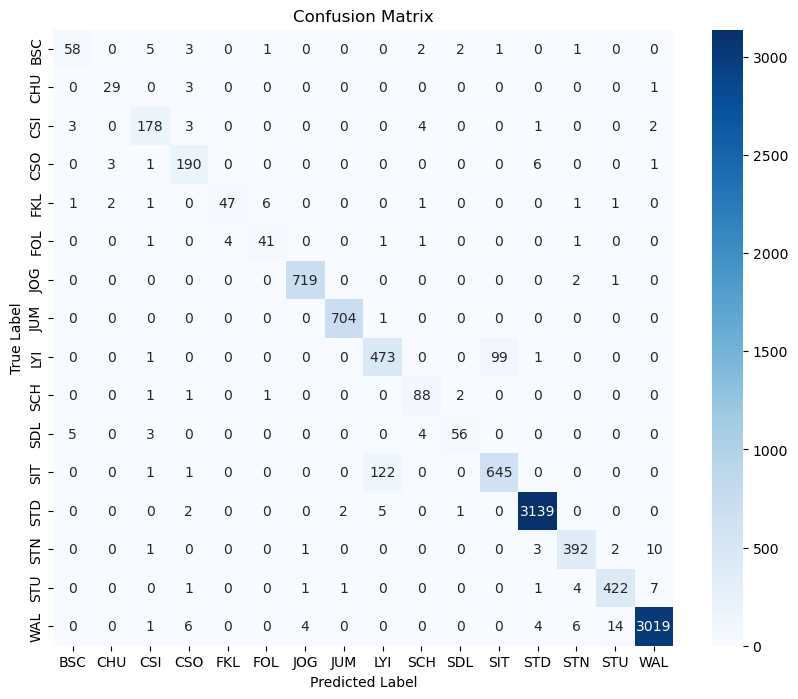

Classification Report:
               precision    recall  f1-score   support

         BSC       0.87      0.79      0.83        73
         CHU       0.85      0.88      0.87        33
         CSI       0.92      0.93      0.92       191
         CSO       0.90      0.95      0.92       201
         FKL       0.92      0.78      0.85        60
         FOL       0.84      0.84      0.84        49
         JOG       0.99      1.00      0.99       722
         JUM       1.00      1.00      1.00       705
         LYI       0.79      0.82      0.80       574
         SCH       0.88      0.95      0.91        93
         SDL       0.92      0.82      0.87        68
         SIT       0.87      0.84      0.85       769
         STD       0.99      1.00      1.00      3149
         STN       0.96      0.96      0.96       409
         STU       0.96      0.97      0.96       437
         WAL       0.99      0.99      0.99      3054

    accuracy                           0.96     10587
  

In [15]:
label_classes = [
    'BSC', 'CHU', 'CSI', 'CSO', 'FKL', 'FOL', 
    'JOG', 'JUM', 'LYI', 'SCH', 'SDL', 'SIT', 
    'STD', 'STN', 'STU', 'WAL'
]
metrics = evaluate_model(model, X_test, y_test, label_classes=label_classes)
